<a href="https://colab.research.google.com/github/rmiller34/ATMS-597-Project-5/blob/master/Tree_Project_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
#change directory to the right spot
import os 
os.chdir('/content/gdrive/My Drive/ATMS_597_Project_5')

### Read all years data file
from datetime import datetime
import pandas as pd

!pip install metpy
from metpy.io import parse_metar_to_dataframe
import glob
import numpy as np


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
     |████████████████████████████████| 327kB 3.2MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 194kB 50.1MB/s 


Cannot import USCOUNTIES and USSTATES without Cartopy installed.


In [0]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import brier_score_loss
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np


In [22]:

# Read data
filename= 'decoded_metar_FINAL.csv'
decoded_metar_dataset=pd.read_csv(filename,dtype={'current_wx1':str})
decoded_metar_dataset

##Codes \ Rain: RA, FZRA, TSRA (value 0) \ Snow: SN, SNDZ (value 1)



,Unnamed: 0,date_time,station_id,latitude,longitude,elevation,date_time.1,wind_direction,wind_speed,current_wx1,air_temperature,dew_point_temperature,altimeter,present_weather,past_weather,past_weather2,eastward_wind,northward_wind,month,fzn_or_liq
0,1,2000-01-01 00:55:00,KMSN,43.13,-89.35,261,2000-01-01 00:55:00,320.0,6.0,-SN,-6.0,-9.0,29.92,71,0,0,3.856726,-4.596267,1,1
1,2,2000-01-01 01:00:00,KMSN,43.13,-89.35,261,2000-01-01 01:00:00,340.0,7.0,-SN,-5.0,-9.0,29.92,71,0,0,2.394141,-6.577848,1,1
2,3,2000-01-01 01:05:00,KMSN,43.13,-89.35,261,2000-01-01 01:05:00,330.0,10.0,-SN,-5.0,-10.0,29.92,71,0,0,5.000000,-8.660254,1,1
3,4,2000-01-01 01:10:00,KMSN,43.13,-89.35,261,2000-01-01 01:10:00,320.0,8.0,-SN,-6.0,-10.0,29.93,71,0,0,5.142301,-6.128356,1,1
4,5,2000-01-01 01:15:00,KMSN,43.13,-89.35,261,2000-01-01 01:15:00,320.0,8.0,-SN,-6.0,-10.0,29.93,71,0,0,5.142301,-6.128356,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175199,412969,2019-12-31 15:25:00,KMSN,43.13,-89.35,261,2019-12-31 15:25:00,300.0,8.0,-SN,-4.0,-8.0,29.69,71,0,0,6.928203,-4.000000,12,1
175200,412970,2019-12-31 15:30:00,KMSN,43.13,-89.35,261,2019-12-31 15:30:00,300.0,9.0,-SN,-4.0,-8.0,29.69,71,0,0,7.794229,-4.500000,12,1
175201,412971,2019-12-31 15:35:00,KMSN,43.13,-89.35,261,2019-12-31 15:35:00,300.0,8.0,-SN,-4.0,-8.0,29.69,71,0,0,6.928203,-4.000000,12,1
175202,412972,2019-12-31 15:40:00,KMSN,43.13,-89.35,261,2019-12-31 15:40:00,290.0,10.0,-SN,-4.0,-8.0,29.69,71,0,0,9.396926,-3.420201,12,1


In [0]:
where_snow_rain = [i for i,x in enumerate(decoded_metar_dataset['current_wx1'].to_list()) if ('RA' in x) | ('SN' in x)]
rain_snow = decoded_metar_dataset.iloc[where_snow_rain]

In [0]:
rain_snow.index = pd.to_datetime(rain_snow.index)

In [0]:
exclude_both = [i for i,x in enumerate(rasn['current_wx1'].to_list()) if 'SNRA' not in x]
rain_snow = rain_snow.iloc[exclude_both]

In [14]:

set(rain_snow['current_wx1'].to_list())

{'+RA',
 '+SN',
 '+TSRA',
 '-FZRA',
 '-RA',
 '-SN',
 '-TSRA',
 'FZRA',
 'RA',
 'SN',
 'TSRA'}

In [0]:
rain_snow['snow'] = 0

In [48]:
where_snow = [i for i,x in enumerate(rain_snow['current_wx1'].to_list()) if 'SN' in x]
rain_snow['snow'][where_snow] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:

rain_snow['day_of_year'] = rain_snow.index.dayofyear

In [0]:
features = ['air_temperature', 'wind_speed', 'wind_direction',  
            'air_temperature', 'dew_point_temperature', 
            'altimeter', 'eastward_wind', 
            'northward_wind', 'day_of_year',
            'snow']

rain_snow_sub = rain_snow.dropna(subset = features)
train_X, valid_X, train_y, valid_y = train_test_split(rain_snow_sub[features[:-1]], rain_snow_sub['snow'], 
                                                  test_size = 0.3, random_state = 42)


In [0]:

dtc    = tree.DecisionTreeClassifier()
model  = dtc.fit(train_X, train_y)
prediction = model.predict(valid_X)

In [0]:

valid_prob = model.predict_proba(valid_X)
train_prob = model.predict_proba(train_X)

In [0]:
def get_climo(y, shape):
    climo = (np.size((y == 1).values.nonzero()))/float(np.size(y))
    prob  = np.zeros((shape))
    prob[:,0] = 1-climo
    prob[:,1] = climo

    return prob

In [0]:

train_climo_prob = get_climo(train_y, train_prob.shape)
valid_climo_prob = get_climo(valid_y, valid_prob.shape)

In [0]:

bss_train = 1 - (brier_score_loss(train_y, train_prob[:,1])/brier_score_loss(train_y, train_climo_prob[:,1]))
bss_valid = 1 - (brier_score_loss(valid_y, valid_prob[:,1])/brier_score_loss(valid_y, valid_climo_prob[:,1]))

In [44]:
print('Training Brier skill score: ' + str(bss_train))
print('Validation Brier skill score: ' + str(bss_valid))

Training Brier skill score: 0.9972000027237338
Validation Brier skill score: 0.9502511754091726


In [0]:
fpr, tpr, thresholds = roc_curve(valid_y, valid_prob[:,1])

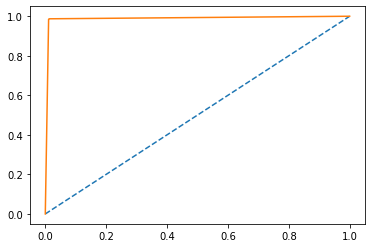

In [33]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.show()